<a href="https://colab.research.google.com/github/ameyanjarlekar/CS-726/blob/main/Copy_of_CS726_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys


%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

percent = 0.1
latent_dims = 30
num_epochs = 20
batch_size = 16
capacity = 64
learning_rate = 5e-4
variational_beta = 1
meas=48
use_gpu = True

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

#img_transform = transforms.Compose([
#    transforms.Resize(64),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
#])
img_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d=32):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)

        #self.fc_dis = nn.Linear(in_features=d*2*8*8, out_features=1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        #self.dropout = nn.Dropout(0.2)
        

        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)

        self.fc_dis = nn.Linear(in_features=d*8*2*2, out_features=1)  
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.dropout = nn.Dropout(0.2)

        #self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
        #super(Discriminator, self).__init__()
        #self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        #self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        #self.conv2_bn = nn.BatchNorm2d(d*2)
        #self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        #self.conv3_bn = nn.BatchNorm2d(d*4)
        #self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        #self.conv4_bn = nn.BatchNorm2d(d*8)
        #self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        #print(np.shape(x))
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        #print(np.shape(x))
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        #print(np.shape(x))
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #print(np.shape(x))
        #x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc_dis(x))


        #x = F.leaky_relu(self.conv1(input), 0.2)
        #x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        #x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        #x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        #x = torch.sigmoid(self.conv5(x))

        return x
    
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
discriminator = discriminator.to(device)


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
class Encoder(nn.Module):
		def __init__(self):


			super(Encoder, self).__init__()      
			c = capacity
			self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
			self.dropout = nn.Dropout(0.2)
			self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
			self.dropout = nn.Dropout(0.2)
			self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
			self.fc_mu = nn.Linear(in_features=c*4*4*4, out_features=latent_dims)
			self.fc_logvar = nn.Linear(in_features=c*4*4*4, out_features=latent_dims)     
			self.dropout = nn.Dropout(0.2)
			self.conv1_bn = nn.BatchNorm2d(c)
			self.conv2_bn = nn.BatchNorm2d(c*2)
			self.conv3_bn = nn.BatchNorm2d(c*4)

		def forward(self, x):
			
			x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
			x = self.dropout(x)
			x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
			x = self.dropout(x)
			x = F.relu(self.conv3_bn(self.conv3(x)))
			x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
			x_mu = self.fc_mu(x)
			x_logvar = self.fc_logvar(x)
			return x_mu, x_logvar
			 # x = F.leaky_relu(self.conv1(input), 0.2)
			 # x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
			 # x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
			 # x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
			 # x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
			 # x_mu = self.fc_mu(x)
			 # x_logvar = self.fc_logvar(x)
			 # return x_mu, x_logvar

class Decoder(nn.Module):
		def __init__(self):
			super(Decoder, self).__init__()
			c = capacity
			self.fc = nn.Linear(in_features=latent_dims, out_features=c*4*4*4)
			self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
			self.dropout = nn.Dropout(0.2)
			self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
			self.dropout = nn.Dropout(0.2)
			self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
			self.conv3_bn = nn.BatchNorm2d(c*2)
			self.conv2_bn = nn.BatchNorm2d(c)
			self.dropout = nn.Dropout(0.2)

				#c = capacity
				#self.fc = nn.Linear(in_features=latent_dims, out_features=c*8*10*8)
				#self.conv4 = nn.ConvTranspose2d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=2, padding=0)
				#self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=2, padding=0)
				#self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=5, stride=2, padding=0)
				#self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=5, stride=2, padding=0)
						
		def forward(self, x):
			x = self.fc(x)
			x = x.view(x.size(0), capacity*4, 4, 4) # unflatten batch of feature vectors to a batch of multi-channel feature maps
			x = F.leaky_relu(self.conv3_bn(self.conv3(x)),0.2)
			x = self.dropout(x)
			x = F.leaky_relu(self.conv2_bn(self.conv2(x)),0.2)
			x = self.dropout(x)
			x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
			return x
			 # x = self.fc(x)
			 # x = x.view(x.size(0), capacity*2, 10, 8) # unflatten batch of feature vectors to a batch of multi-channel feature maps
			 # x = F.relu(self.conv4(x))
			 # x = F.relu(self.conv3(x))
			 # x = F.relu(self.conv2(x))
			 # x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
			 # return x
		
class VariationalAutoencoder(nn.Module):
		def __init__(self):
				super(VariationalAutoencoder, self).__init__()
				self.encoder = Encoder()
				self.decoder = Decoder()
		
		def forward(self, x):
				latent_mu, latent_logvar = self.encoder(x)
				latent = self.latent_sample(latent_mu, latent_logvar)
				x_recon = self.decoder(latent)
				return x_recon, latent_mu, latent_logvar
		
		def latent_sample(self, mu, logvar):
				if self.training:
						# the reparameterization trick
						std = logvar.mul(0.5).exp_()
						eps = torch.empty_like(std).normal_()
						return eps.mul(std).add_(mu)
				else:
						return mu
		
def vae_loss(recon_x, x, mu, logvar):
		# recon_x is the probability of a multivariate Bernoulli distribution p.
		# -log(p(x)) is then the pixel-wise binary cross-entropy.
		# Averaging or not averaging the binary cross-entropy over all pixels here
		# is a subtle detail with big effect on training, since it changes the weight
		# we need to pick for the other loss term by several orders of magnitude.
		# Not averaging is the direct implementation of the negative log likelihood,
		# but averaging makes the weight of the other loss term independent of the image resolution.
		recon_loss = F.binary_cross_entropy(recon_x.view(-1, 3072), x.view(-1, 3072), reduction='sum')
		#recon_loss = torch.mean(torch.square(torch.subtract(recon_x, x)))
		# KL-divergence between the prior distribution over latent vectors
		# (the one we are going to sample from when generating new images)
		# and the distribution estimated by the generator for the given image.
		kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
		
		return recon_loss + variational_beta * kldivergence

def recon_loss(recon_x, x):
		# recon_x is the probability of a multivariate Bernoulli distribution p.
		# -log(p(x)) is then the pixel-wise binary cross-entropy.
		# Averaging or not averaging the binary cross-entropy over all pixels here
		# is a subtle detail with big effect on training, since it changes the weight
		# we need to pick for the other loss term by several orders of magnitude.
		# Not averaging is the direct implementation of the negative log likelihood,
		# but averaging makes the weight of the other loss term independent of the image resolution.
		recon_loss = F.binary_cross_entropy(recon_x.view(-1, 3072), x.view(-1, 3072), reduction='sum')
		#recon_loss = torch.mean(torch.square(torch.subtract(recon_x, x)))
		# KL-divergence between the prior distribution over latent vectors
		# (the one we are going to sample from when generating new images)
		# and the distribution estimated by the generator for the given image.
		
		return recon_loss 
		
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1691583


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
import time
import numpy as np
import matplotlib.pyplot as plt
phi = torch.rand(750,1024)
store= torch.matmul(torch.pinverse(phi),phi)
start_time=time.time()
#disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
gen_optimizer = torch.optim.Adamax(params=vae.parameters(), lr=learning_rate*10, weight_decay=1e-5)
#gen_optimizer = torch.optim.RMSprop(params=vae.parameters(), lr=learning_rate, alpha =0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

vae.train()

discriminator.train()

disc_loss_avg = []
gen_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    i = 0
    for image_batch2, _ in train_dataloader:
        image_batch = torch.rand(batch_size,3,32,32)
        i = i+1
        for i in range(batch_size):
          for j in range(3):
            image_batch[i,j,:,:]=torch.reshape(torch.matmul(store,torch.reshape(image_batch2[i,j,:,:],(1024,1))),(32,32))
        # get dataset image and create real and fake labels for use in the loss
        image_batch2 = image_batch2.to(device)
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)
        #print(image_batch)
        # generate a batch of images from samples of the latent prior
        fake_image_batch, latent_mu, latent_logvar = vae(image_batch)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        #print(np.shape(real_pred))

        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        #print(np.shape(label_real))
    
        disc_loss = torch.mean(torch.square(fake_pred)) + torch.mean(torch.square(1-real_pred))
            #F.binary_cross_entropy(real_pred, label_real) +
            #F.binary_cross_entropy(fake_pred, label_fake))
        
        if (epoch % 6) == 0 :
 #         disc_optimizer.zero_grad()
          disc_loss.backward()
 #        disc_optimizer.step()
        
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        #gen_loss = percent*F.binary_cross_entropy(fake_pred, label_real) + (1-percent)*vae_loss(fake_image_batch, image_batch, latent_mu, latent_logvar)  
        vaegenloss = (1-percent)*vae_loss(fake_image_batch, image_batch2, latent_mu, latent_logvar) 
        gen_loss = percent*torch.mean(torch.square(1-fake_pred)) + vaegenloss
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
       # if epoch > 5:
       #   for p in vae.parameters():
        #        with torch.no_grad():
         #           print("Norm of gradient:", torch.sum(p.grad.data**2))
         # print(num_batches)
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
    #print(i)    
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))
end_time=time.time()
print('time_taken:',end_time-start_time)

plt.ion()
gen_loss_avg_20000 = [x / 50000 for x in gen_loss_avg]
fig = plt.figure()
plt.plot(gen_loss_avg_20000, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training ...
Epoch [1 / 20] average loss generator vs. discrim.: 26400.381607 vs. 0.514783
Epoch [2 / 20] average loss generator vs. discrim.: 26395.284241 vs. 0.514306
Epoch [3 / 20] average loss generator vs. discrim.: 26391.931158 vs. 0.514322
Epoch [4 / 20] average loss generator vs. discrim.: 26391.245458 vs. 0.514461
Epoch [5 / 20] average loss generator vs. discrim.: 26390.106498 vs. 0.514340
Epoch [6 / 20] average loss generator vs. discrim.: 26386.806283 vs. 0.514306
Epoch [7 / 20] average loss generator vs. discrim.: 26385.860752 vs. 0.514225


In [ ]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch2, _ in test_dataloader:
    image_batch = torch.rand(batch_size,3,32,32)
    with torch.no_grad():
        for i in range(batch_size):
          for j in range(3):
            image_batch[i,j,:,:]=torch.reshape(torch.matmul(store,torch.reshape(image_batch2[i,j,:,:],(1024,1))),(32,32))    
        image_batch = image_batch.to(device)
        image_batch2 = image_batch2.to(device)
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = recon_loss(image_batch_recon, image_batch2)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 28487.139919


torch.Size([16, 3, 32, 32])
Original images


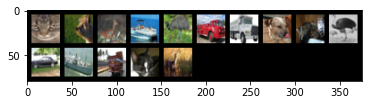

VAE reconstruction:
tensor(30698.3848, device='cuda:0')


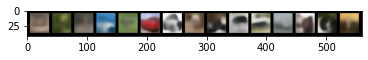

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        imagesa = images.to(device)
        images, _, _ = model(imagesa)
        print(recon_loss(images,imagesa))
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 100, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images2, labels = iter(test_dataloader).next()
images = torch.rand(batch_size,3,32,32)
for i in range(batch_size):
  for j in range(3):
    images[i,j,:,:]=torch.reshape(torch.matmul(store,torch.reshape(images2[i,j,:,:],(1024,1))),(32,32))
print(np.shape(images))
# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images2[1:50],10,5))
plt.show()
# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)